<a href="https://colab.research.google.com/github/Tonyrj3268/DS4CS-FinalProject/blob/main/%E6%96%B0%E5%9E%8B%E6%BC%94%E7%AE%97%E6%B3%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# **Member**
*   林家誠, 109306066, MIS
*   陳彥竹, 1093060xx, MIS



# **Title**
**url之分析...**

# **Problem Definition**
**Problem Definition**

# **Dataset**
**Dataset**
**介紹**



# **description of your models**
**models**
**介紹**



# **result**
**介紹**



# **discussion**
**介紹**


# 程式碼

## 安裝套件

In [1]:
!pip install transformers
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 69.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 90.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 下載和解壓檔案

In [2]:
import requests
import zipfile

url = 'https://github.com/Tonyrj3268/DS4CS-FinalProject/raw/main/archive.zip'
response = requests.get(url)
with open('archive.zip', 'wb') as file:
    file.write(response.content)
with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

## 加載模組

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
import string
from urllib.parse import urlparse
import re
from transformers import BertModel, BertTokenizer
import torch
from imblearn.under_sampling import RandomUnderSampler
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

## gpu check

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


## 分析資料集

In [5]:
df = pd.read_csv('/content/malicious_phish.csv')
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


由於資料集的label分配不均，且資料太過龐大(65萬筆)，使用欠採樣平衡數據集並且縮小訓練資料量，原本呈現之結果為欠採樣後之訓練數量。


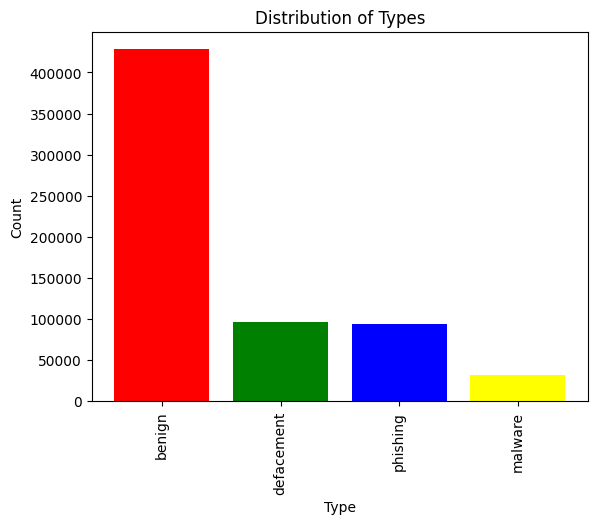

In [6]:
category_counts = df['type'].value_counts()
colors = ['red', 'green', 'blue', 'yellow']
plt.bar(category_counts.index, category_counts.values, color=colors)
plt.xlabel("Type")
plt.ylabel("Count")
plt.title("Distribution of Types")
plt.xticks(rotation='vertical')
plt.show()

In [11]:
X = df[['url']]
y = df['type'] 

under_sampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = under_sampler.fit_resample(X, y)

print("處理後的樣本數:", len(X_resampled))
print("處理後的樣本分佈:")
print(y_resampled.value_counts())

re_df = pd.concat([X_resampled, y_resampled], axis=1)
re_df = re_df.sample(n=10000, random_state=42)

處理後的樣本數: 130080
處理後的樣本分佈:
benign        32520
defacement    32520
malware       32520
phishing      32520
Name: type, dtype: int64


# 預處理

## 特殊字符
計算特殊字符之數量，若完全沒該字符出現，則捨棄此字符欄位。

In [12]:
special_chars = ['!', '@', '#', '$', '%', '^', '&', '*', '(', ')', '_', '-', '+', '=',\
         '{', '}', '[', ']', '|', '\\', ':', ';', '<', '>', ',', '.', '?', '/', '`', '~']  # 定义特殊字符列表

for a in special_chars:
    re_df[a] = re_df['url'].apply(lambda i: i.count(a))
absent_chars = [char for char in special_chars if re_df[char].sum() == 0]
re_df.drop(columns=absent_chars, inplace=True)

## https 檢查 & url長度計算
檢查是否帶有https字串，如有則計為1。  
計算url之總長度

In [13]:
def httpSecure(url):
    http = urlparse(url).scheme
    match = str(http)
    if match=='https':
        return 1
    else:
        return 0
re_df['https'] = re_df['url'].apply(lambda i: httpSecure(i))
re_df['url_len'] = re_df['url'].apply(lambda i: len(str(i)))

In [14]:
re_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 115240 to 117856
Data columns (total 32 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      10000 non-null  object
 1   type     10000 non-null  object
 2   !        10000 non-null  int64 
 3   @        10000 non-null  int64 
 4   #        10000 non-null  int64 
 5   $        10000 non-null  int64 
 6   %        10000 non-null  int64 
 7   ^        10000 non-null  int64 
 8   &        10000 non-null  int64 
 9   *        10000 non-null  int64 
 10  (        10000 non-null  int64 
 11  )        10000 non-null  int64 
 12  _        10000 non-null  int64 
 13  -        10000 non-null  int64 
 14  +        10000 non-null  int64 
 15  =        10000 non-null  int64 
 16  {        10000 non-null  int64 
 17  }        10000 non-null  int64 
 18  [        10000 non-null  int64 
 19  ]        10000 non-null  int64 
 20  |        10000 non-null  int64 
 21  \        10000 non-null  int6

## 加載bert模型

In [15]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')#bert-base-uncased
model = BertModel.from_pretrained('bert-base-uncased').to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## 切割url
1.  將url的特殊字符去除，獲得剩餘單字詞的集合，例如:www.example.com => [www, example, com]。
2.  使用已訓練好的tokenizer獲得單詞之token ID，將token集合放入bert 模型生成1維768長度的值
3.  display mode預估訓練時間3分半

In [16]:
def urlSplitBatch(urls):
    url_parts = [re.sub(r'\s+', ' ', re.sub(r'[^\w\s]', ' ', url)).split(' ') for url in urls]
    tokens = [tokenizer.batch_encode_plus(parts, padding=True, truncation=True, return_tensors='pt') for parts in url_parts]
    input_ids = [token["input_ids"] for token in tokens]
    url_vectors = []
    for ids in input_ids:
      with torch.no_grad():
          ids = ids.to(device)
          last_hidden_states = model(ids)[0]
      url_vectors.append(last_hidden_states.mean(dim=[0, 1]).unsqueeze(0))

    url_vectors = torch.cat(url_vectors, dim=0).to(device)
    return url_vectors


# 在主要迴圈中使用批次處理
BATCH_SIZE = 1000 # 你可以根據你的硬體配置和需求來調整批次的大小
word_vector = []
rows_to_drop = []
total = len(re_df['url'])
checkpoint = total // 100
for start in range(0, total, BATCH_SIZE):
  end = min(start + BATCH_SIZE, total)
  batch_indices = re_df.index[start:end]
  batch = re_df['url'].loc[batch_indices]
  try:
    split_urls = urlSplitBatch(batch)  # 對整個批次進行split操作
  except:
    print(f"第{start}批資料集發生錯誤，跳過並移除")
    rows_to_drop.extend(batch_indices)  # 若split操作失敗，將整個批次的索引加入要刪除的列表
    continue

  list_from_tensor = split_urls.tolist()
  word_vector.extend(list_from_tensor)

  if end % checkpoint == 0:
      print("已完成：{:.0f}%".format(end / total * 100))

已完成：10%
已完成：20%
已完成：30%
已完成：40%
已完成：50%
已完成：60%
已完成：70%
已完成：80%
已完成：90%
已完成：100%


In [17]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        mid_dim = (input_dim + encoding_dim) // 2  # add an intermediate layer with average dimension
        
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, mid_dim),
            nn.ReLU(),
            nn.Linear(mid_dim, encoding_dim),
            nn.ReLU()
        )
        
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, mid_dim),
            nn.ReLU(),
            nn.Linear(mid_dim, input_dim),
        )

    def forward(self, x):
        x = torch.relu(self.encoder(x))
        x = self.decoder(x)
        return x


In [19]:
input_dim = len(word_vector[0])  # number of features
encoding_dim = 200  # desired dimension after encoding

model = AutoEncoder(input_dim, encoding_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
EPOCHES = 20

features = torch.from_numpy(np.array(word_vector)).float().to(device)
dataset = TensorDataset(features)
data_loader = DataLoader(dataset, batch_size=128, shuffle=True)

for epoch in range(EPOCHES):
    for feature in data_loader:
        # forward
        outputs = model(feature[0])
        loss = criterion(outputs, feature[0])
        
        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'Epoch [{epoch+1}/{EPOCHES}], Loss: {loss.item():.4f}')
with torch.no_grad():
    encoded_data = model.encoder(features)

Epoch [1/20], Loss: 0.0029
Epoch [2/20], Loss: 0.0029
Epoch [3/20], Loss: 0.0013
Epoch [4/20], Loss: 0.0016
Epoch [5/20], Loss: 0.0020
Epoch [6/20], Loss: 0.0016
Epoch [7/20], Loss: 0.0020
Epoch [8/20], Loss: 0.0019
Epoch [9/20], Loss: 0.0011
Epoch [10/20], Loss: 0.0015
Epoch [11/20], Loss: 0.0011
Epoch [12/20], Loss: 0.0015
Epoch [13/20], Loss: 0.0018
Epoch [14/20], Loss: 0.0008
Epoch [15/20], Loss: 0.0014
Epoch [16/20], Loss: 0.0014
Epoch [17/20], Loss: 0.0009
Epoch [18/20], Loss: 0.0012
Epoch [19/20], Loss: 0.0014
Epoch [20/20], Loss: 0.0011


## 切分成3種特徵
1.  純單字詞矩陣
2.  純原url之特徵矩陣
3.  上面兩種之結合

In [20]:
word_vector_array = encoded_data.cpu()
feature_array = re_df.drop(['url', 'type'], axis=1).drop(rows_to_drop).to_numpy()
merged_array = np.hstack((feature_array, word_vector_array))

target = pd.get_dummies(re_df['type'], columns=['type'])

In [21]:
features_train, features_test, labels_train, labels_test = train_test_split(merged_array, target.values, test_size=0.2, random_state=42)
features_train, features_val, labels_train, labels_val = train_test_split(features_train, labels_train, test_size=0.2, random_state=42)

# numpy轉換tensors
features_train = torch.tensor(features_train, dtype=torch.float32)
labels_train = torch.tensor(labels_train, dtype=torch.float32)
features_val = torch.tensor(features_val, dtype=torch.float32)
labels_val = torch.tensor(labels_val, dtype=torch.float32)
features_test = torch.tensor(features_test, dtype=torch.float32)
labels_test = torch.tensor(labels_test, dtype=torch.float32)

train_dataset = TensorDataset(features_train, labels_train)
val_dataset = TensorDataset(features_val, labels_val)
test_dataset = TensorDataset(features_test, labels_test)

batch_size = 1
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## 神經網路
使用神經網路對三種資料集進行訓練

In [22]:
class FeatureNet(nn.Module):
    def __init__(self, x_len):
        super(FeatureNet, self).__init__()
        self.fc1 = nn.Linear(x_len, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 4)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.log_softmax(self.fc3(x), dim=1)
        return x
class WordNet(nn.Module):
    def __init__(self, x_len):
        super(WordNet, self).__init__()
        self.fc1 = nn.Linear(x_len, 600)
        self.bn1 = nn.BatchNorm1d(600)
        self.fc2 = nn.Linear(600, 400)
        self.bn2 = nn.BatchNorm1d(400)
        self.fc3 = nn.Linear(400, 200)
        self.bn3 = nn.BatchNorm1d(200)
        self.fc4 = nn.Linear(200, 100)
        self.dropout = nn.Dropout(0.5)
        self.fc5 = nn.Linear(100, 4)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = torch.log_softmax(self.fc5(x), dim=1)  # 使用 LogSoftmax
        return x

In [23]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0


In [39]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader)
    train_loss = 0
    correct = 0
    for batch, (X, y) in enumerate(dataloader):
      print(X.shape)
      print(y.shape)
      X = X.to(device)
      y = y.to(device)
      # Compute prediction and loss
      y_pred = model(X)

      loss = loss_fn(y_pred, y.float())
      train_loss += loss.item()

      optimizer.zero_grad()# 梯度初始化为零
      loss.backward()# 反向传播求梯度
      optimizer.step()# 更新所有参数

      #計算數字機率分布
      pred = y_pred.argmax(dim=1, keepdim=True)
      correct += pred.eq(y.argmax(dim=1, keepdim=True).view_as(pred)).sum().item() 

    train_loss /= size
    accuracy = 100. * correct / size

    return train_loss, accuracy
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            y_pred = model(X)

            loss = loss_fn(y_pred, y.float())
            test_loss += loss.item()

            pred = y_pred.argmax(dim=1, keepdim=True)
            correct += pred.eq(y.argmax(dim=1, keepdim=True).view_as(pred)).sum().item()

    test_loss /= size
    correct = 100. * correct / size

    return test_loss, correct
def val_loop(dataloader, model, loss_fn):
    running_loss = 0.0
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.argmax(dim=1).to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            running_loss += loss.item()

    avg_val_loss = running_loss / len(dataloader)

    return avg_val_loss

In [ ]:
def init_weights_kaiming_normal_(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.01)

In [40]:
model_wt = WordNet(len(merged_array[0])).to(device)
model_wt.apply(init_weights_kaiming_normal_)
feature_arrays = merged_array
Epoch = 5
loss_results = {}
accuracy_results = {}

early_stopping = EarlyStopping(patience=5, verbose=True)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model_wt.parameters())

losses = []
accuracies = []

for epoch in range(Epoch):
  loss, _ = train_loop(train_dataloader, model_wt, criterion, optimizer)
  if epoch % 1 == 0:
      print(f'Epoch {epoch + 1}, Training Loss: {loss}')

  avg_val_loss = val_loop(val_dataloader, model_wt, criterion)
  print(f'Epoch {epoch + 1}, Validation Loss: {avg_val_loss}')
  # Check early stopping
  early_stopping(avg_val_loss)
  if early_stopping.early_stop:
      print("Early stopping")
      break

torch.Size([1, 230])
torch.Size([1, 4])
torch.Size([1, 230])


ValueError: ignored

In [ ]:
for arr in ["WtoF","FtoW"]:
  
  if arr == "WtoF":
    mymodels[1].eval()
    res = mymodels[1](torch.tensor(word_vector_array, dtype=torch.float32).to(device))
    combined_array = np.concatenate([feature_array, res.cpu().detach().numpy()], axis=1)
  else:
    mymodels[0].eval()
    res = mymodels[0](torch.tensor(feature_array, dtype=torch.float32).to(device))
    combined_array = np.concatenate([word_vector_array, res.cpu().detach().numpy()], axis=1)

  early_stopping = EarlyStopping(patience=5, verbose=True)
  print(f"\nTraining model with: {feature_name}\n")
  features_train, features_test, labels_train, labels_test = train_test_split(combined_array, target.values, test_size=0.2, random_state=42)
  features_train, features_val, labels_train, labels_val = train_test_split(features_train, labels_train, test_size=0.2, random_state=42)

  # numpy轉換tensors
  features_train = torch.tensor(features_train, dtype=torch.float32)
  labels_train = torch.tensor(labels_train, dtype=torch.float32)
  features_val = torch.tensor(features_val, dtype=torch.float32)
  labels_val = torch.tensor(labels_val, dtype=torch.float32)
  features_test = torch.tensor(features_test, dtype=torch.float32)
  labels_test = torch.tensor(labels_test, dtype=torch.float32)

  train_dataset = TensorDataset(features_train, labels_train)
  val_dataset = TensorDataset(features_val, labels_val)
  test_dataset = TensorDataset(features_test, labels_test)

  batch_size = 64
  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
  val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

  net = FeatureNet(len(combined_array[0])).to(device)
  criterion = nn.NLLLoss()
  optimizer = optim.Adam(net.parameters())

  losses = []
  accuracies = []
  Epoch = 30
  for epoch in range(Epoch):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader):
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.argmax(dim=1).to(device)
      outputs = net(inputs)

      optimizer.zero_grad()
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
    avg_train_loss = running_loss / len(train_dataloader)
    losses.append(avg_train_loss)
    print(f'[{feature_name}] Epoch {epoch + 1}, Training Loss: {avg_train_loss}')
    
    # Validation step
    running_loss = 0.0
    net.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for i, data in enumerate(val_dataloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.argmax(dim=1).to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

    avg_val_loss = running_loss / len(val_dataloader)
    print(f'[{feature_name}] Epoch {epoch + 1}, Validation Loss: {avg_val_loss}')
    # Check early stopping
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    # Test the model
    net.eval()  # It's important to set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
      for data in test_dataloader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.argmax(dim=1).to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = correct / total
    accuracies.append(accuracy)
    print(f'[Epoch {epoch + 1}, Accuracy: {accuracy}')

    net.train()  # Reset the model to training mode
  loss_results[f"Conbined array {arr}"] = losses
  accuracy_results[f"Conbined array {arr}"] = accuracies


Training model with: Merged Array



<ipython-input-21-f2aa713d4d2d>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  res = mymodels[1](torch.tensor(word_vector_array, dtype=torch.float32).to(device))


[Merged Array] Epoch 1, Training Loss: 0.707103590965271
[Merged Array] Epoch 1, Validation Loss: 0.49596110939979554
[Epoch 1, Accuracy: 0.8175
[Merged Array] Epoch 2, Training Loss: 0.4122728183865547
[Merged Array] Epoch 2, Validation Loss: 0.47690396428108217
[Epoch 2, Accuracy: 0.835
[Merged Array] Epoch 3, Training Loss: 0.33934702813625334
[Merged Array] Epoch 3, Validation Loss: 0.43155460596084594
[Epoch 3, Accuracy: 0.8415
[Merged Array] Epoch 4, Training Loss: 0.3255517338216305
[Merged Array] Epoch 4, Validation Loss: 0.4389889621734619
EarlyStopping counter: 1 out of 5
[Epoch 4, Accuracy: 0.844
[Merged Array] Epoch 5, Training Loss: 0.3243315322697163
[Merged Array] Epoch 5, Validation Loss: 0.479797488451004
EarlyStopping counter: 2 out of 5
[Epoch 5, Accuracy: 0.8375
[Merged Array] Epoch 6, Training Loss: 0.32765089884400367
[Merged Array] Epoch 6, Validation Loss: 0.4158769881725311
[Epoch 6, Accuracy: 0.8465
[Merged Array] Epoch 7, Training Loss: 0.3179100316017866
[Me

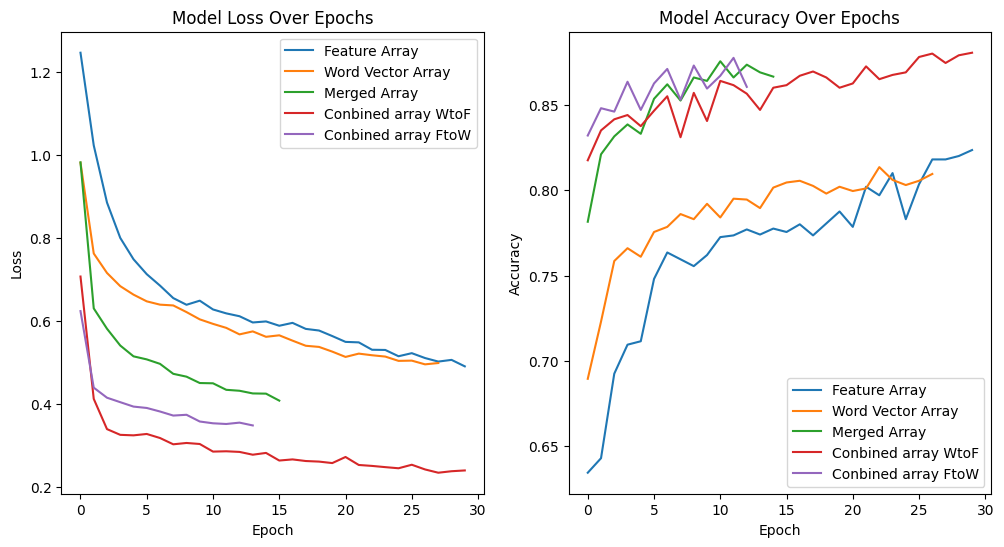

In [ ]:
# Draw losses of all features in one graph
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for feature_name, losses in loss_results.items():
    plt.plot(losses, label=feature_name)
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Draw accuracies of all features in one graph
plt.subplot(1, 2, 2)
for feature_name, accuracies in accuracy_results.items():
    plt.plot(accuracies, label=feature_name)
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()